In [2]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import numpy 
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout,Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [32]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
New_claim = pd.read_csv('D:/PACCAR/Primary tables/dbo.NewClaims_table.csv',usecols=["RprDt","TotProAmt","RequestedTotAmt","DealerCd"])

In [33]:
New_claim['Region'] = "Americas"
New_claim.Region[New_claim.DealerCd.map(lambda x: x.startswith('P'))] = "PAC"
#New_claim = New_claim[New_claim.Region == "PAC"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
New_claim.RprDt = New_claim.RprDt.astype('datetime64[ns]')
New_claim= New_claim[New_claim.RprDt < '2017-4-1']
New_cl = New_claim[['RprDt','TotProAmt']].assign(Timestamp=pd.to_datetime(New_claim.RprDt, unit='ms')).resample('D', on='Timestamp').sum().reset_index().interpolate()


In [35]:
New_cl['year'] = New_cl.Timestamp.dt.year
New_cl.TotProAmt[New_cl.TotProAmt==0] = np.nan
New_cl['TotProAmt'].fillna(New_cl.groupby("year")["TotProAmt"].transform("mean"), inplace=True)
New_cl = New_cl.drop('year',axis=1)
New_cl = New_cl.drop('Timestamp',axis=1)
New_cl = New_cl.fillna(1082)

#del(New_claim)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:

dataset = New_cl.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [37]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [38]:
# create and fit the LSTM network
model = Sequential()
layers = [1, 50, 100, 1]
model.add(LSTM(layers[1],input_shape=(1, look_back),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layers[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[3]))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 9s - loss: 0.0014
Epoch 2/100
 - 8s - loss: 0.0013
Epoch 3/100
 - 7s - loss: 0.0012
Epoch 4/100
 - 8s - loss: 0.0011
Epoch 5/100
 - 8s - loss: 0.0010
Epoch 6/100
 - 8s - loss: 9.6752e-04
Epoch 7/100
 - 8s - loss: 9.2710e-04
Epoch 8/100
 - 8s - loss: 9.1756e-04
Epoch 9/100
 - 8s - loss: 8.9575e-04
Epoch 10/100
 - 8s - loss: 9.0266e-04
Epoch 11/100
 - 8s - loss: 9.0327e-04
Epoch 12/100
 - 8s - loss: 8.8594e-04
Epoch 13/100
 - 8s - loss: 8.8699e-04
Epoch 14/100
 - 8s - loss: 8.8115e-04
Epoch 15/100
 - 8s - loss: 8.7222e-04
Epoch 16/100
 - 8s - loss: 8.7866e-04
Epoch 17/100
 - 8s - loss: 8.7044e-04
Epoch 18/100
 - 8s - loss: 8.5804e-04
Epoch 19/100
 - 8s - loss: 8.6664e-04
Epoch 20/100
 - 8s - loss: 8.6264e-04
Epoch 21/100
 - 8s - loss: 8.7181e-04
Epoch 22/100
 - 8s - loss: 8.6119e-04
Epoch 23/100
 - 8s - loss: 8.4980e-04
Epoch 24/100
 - 8s - loss: 8.4490e-04
Epoch 25/100
 - 8s - loss: 8.3874e-04
Epoch 26/100
 - 8s - loss: 8.4487e-04
Epoch 27/100
 - 8s - loss: 8.4761e-04
Epo

In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testP =testPredict
test_y = testY

Train Score: 266.29 RMSE
Test Score: 1167.83 RMSE


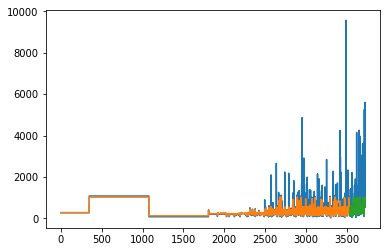

In [40]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

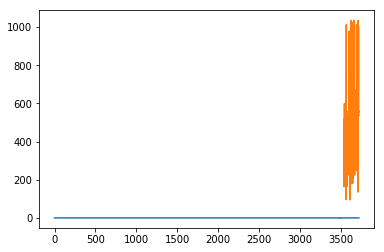

In [43]:
plt.plot((dataset))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

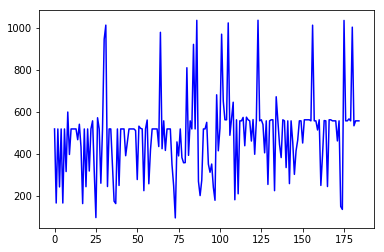

In [41]:
plt.plot((testPredict.reshape(-1,1)),color='blue')
plt.show()

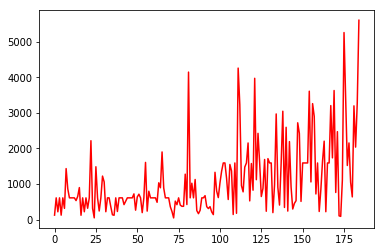

In [42]:
plt.plot((testY.reshape(-1,1)),color='red')
plt.show()

In [ ]:
actulclaim = (testY.reshape(-1,1))
pred = (testPredict.reshape(-1,1))

In [ ]:
actulclaim

In [ ]:
pred_df = pd.DataFrame(actulclaim)

In [ ]:
pred_df['predicted'] = pd.DataFrame(pred)

In [ ]:
pred_df.to_csv('D:/PACCAR/Primary tables/pred_results_ts.csv')

In [ ]:
New_cl